# Deblurring with Nuclear Norm Prior

In [1]:
import numpy as np
import numpy.fft as fft
import cv2 as cv
import pywt as wt
import matplotlib.pyplot as plt

from PIL import Image
from scipy.signal import convolve2d
from sklearn.feature_extraction.image import extract_patches_2d
from tqdm.notebook import tqdm

## Load an image

In [2]:
BASE_DIR = '../../resources/images/deblurring'
dark_sky_img = cv.cvtColor(cv.imread(f'{BASE_DIR}/dark-sky.jpg'), cv.COLOR_BGR2RGB)
dark_sky_rec = dark_sky_img[300:428, 100:228, :]
print(f'The dark sky image has {dark_sky_img.shape} dimensions')

The dark sky image has (460, 700, 3) dimensions


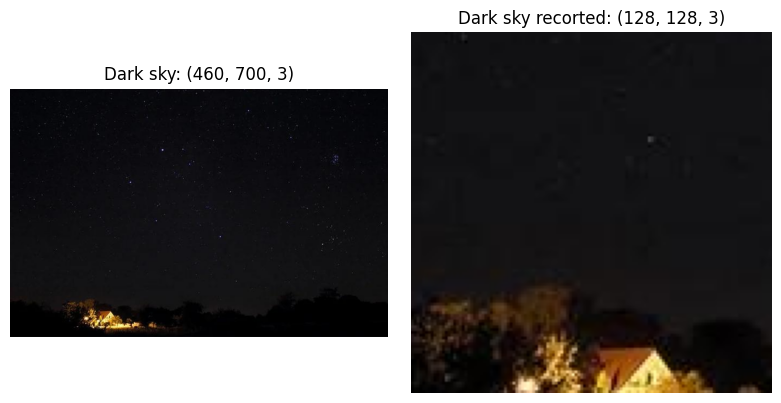

In [3]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(dark_sky_img)
plt.title(f'Dark sky: {dark_sky_img.shape}')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(dark_sky_rec)
plt.title(f'Dark sky recorted: {dark_sky_rec.shape}')
plt.axis('off')
plt.tight_layout()
plt.show()

Extract luminance component in LAB space.

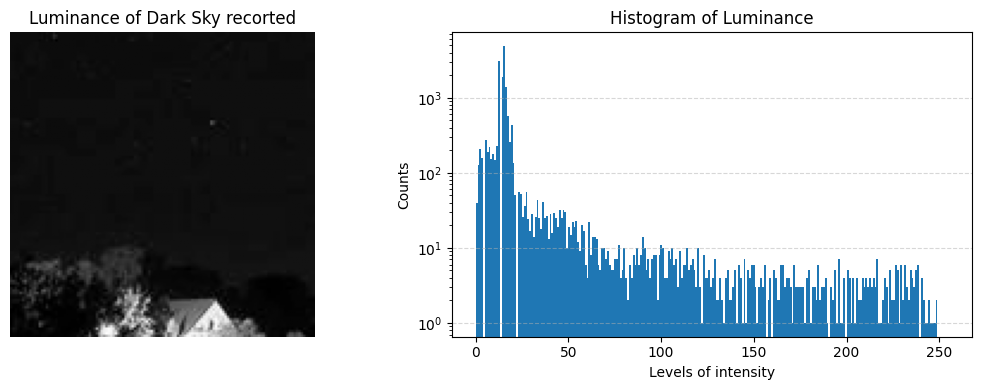

In [4]:
dark_sky_l, dark_sky_a, dark_sky_b = cv.split(cv.cvtColor(dark_sky_rec, cv.COLOR_RGB2LAB))

plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.imshow(dark_sky_l, cmap='gray')
plt.title('Luminance of Dark Sky recorted')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.hist(dark_sky_l.ravel(), bins=256, range=(0, 255))
plt.title('Histogram of Luminance')
plt.xlabel('Levels of intensity')
plt.ylabel('Counts')
plt.yscale('log')
plt.grid(axis='y', ls='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Affect image with blurring

Get a gaussian kernel normalized.

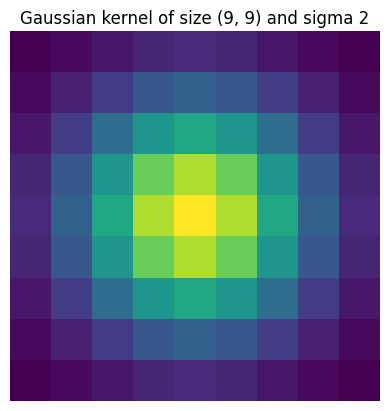

In [5]:
KERNEL_SZ = 9
KERNEL_STD = 2

H = cv.getGaussianKernel(ksize=KERNEL_SZ, sigma=KERNEL_STD)
H = H @ H.T

H = H / np.sum(H)

plt.imshow(H)
plt.axis('off')
plt.title(f'Gaussian kernel of size {H.shape} and sigma {KERNEL_STD}')
plt.show()

Pad a kernel for resize up to image size.

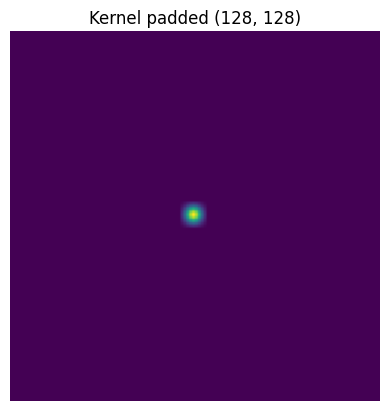

In [6]:
def pad_kernel_to_image_size(H_kernel, image_shape):
    H_padded = np.zeros(image_shape)
    kh, kw = H_kernel.shape
    ih, iw = image_shape

    # Posición para centrar el kernel
    top = (ih - kh) // 2
    left = (iw - kw) // 2

    H_padded[top:top + kh, left:left + kw] = H_kernel
    return H_padded

H_padded = pad_kernel_to_image_size(H, dark_sky_l.shape)

plt.imshow(H_padded)
plt.title(f'Kernel padded {H_padded.shape}')
plt.axis('off')
plt.show()

Apply blurring to luminance.

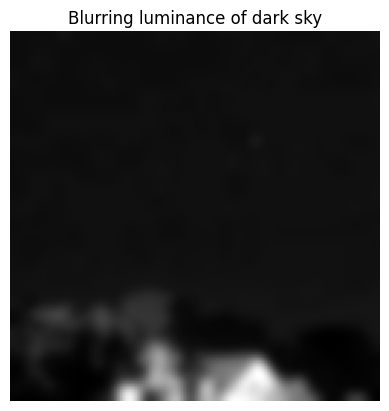

In [7]:
Y = convolve2d(dark_sky_l, H, mode='same', boundary='symm')
Y = (Y - Y.min()) / (Y.max() - Y.min())

plt.imshow(Y, cmap='gray')
plt.title('Blurring luminance of dark sky')
plt.axis('off')
plt.show()

## Evaluate the errors

Define functions to compute the errors:

In [8]:
def mae_error(img_est, img_ref):
    mae = np.mean(np.abs(img_est - img_ref))
    return mae
def rmse_error(img_est, img_ref):
    rmse = np.sqrt(np.mean(np.power(img_ref - img_est, 2)))
    return rmse
def compute_errors(img_est, img_ref):
    return [mae_error(img_est, img_ref), rmse_error(img_est, img_ref)]

Define an bar plotter to represent errors:

In [9]:
def bar_errors(errors, x_text='', y_text='', title_text='', offset_text=1, colors=['green', 'dodgerblue']):
    err_labels = ['MAE', 'RMSE']
    plt.bar(err_labels, errors, color=colors)
    for idx, val in enumerate(errors):
        val_f = f'{val:.4f}'
        plt.text(idx, val + offset_text, val_f, ha='center')
    plt.ylim(0, np.max(errors) + np.max(errors) * .2)
    plt.xlabel(x_text)
    plt.ylabel(y_text)
    plt.title(title_text)

## Deblurring using full matrix

The formulation of problem is:
$$
\frac{1}{2} \Vert H * X - Y \Vert_2^2 + \frac{\rho}{2} \Vert X - Z^k + C^k \Vert_2^2
$$
$$
\begin{alignat}{1}
\nabla_X &= 0
\end{alignat}
$$

The formulation of used steps are:
$$
\begin{gather}
X_{k + 1} = \mathcal{F}^{-1} \Bigg\{ 
\frac{\mathcal{F}\{ H^+ * Y \} - \rho \mathcal{F}\{ C^k - Z^k \}} {\mathcal{F}\{ H^+ * H \} + \rho} 
\Bigg\} \\
\text{where } H^+ = H \text{ rotated 180 degrees}
\end{gather}
$$

Implements the steps:

In [10]:
def soft_thresholding(x, tau):
    return np.sign(x) * np.maximum(np.abs(x) - tau, 0.0)

def normalizer(img):
    img = (img - img.min()) / (img.max() - img.min())
    return img

def admm(H, Y, lambd=0.1, rho=1, max_iter=100, tol=1e-4):
    m, n = Y.shape
    X = Y.copy()
    Z = np.zeros((m, n))
    C = np.zeros((m, n))

    H_rot180 = np.rot90(H, k=2)
    
    H_frr = fft.fft2(fft.ifftshift(H))
    H_rot180_frr = fft.fft2(fft.ifftshift(H_rot180))
    Y_frr = fft.fft2(Y)

    history = []
    step_final = 0
    for i in range(max_iter):
        X_old = X.copy()

        # x-update
        diff_c_z = fft.ifft2(C - Z)
        x_fourier = ((H_rot180_frr * Y_frr) - rho * diff_c_z) / (H_rot180_frr * H_frr + rho)
        X = fft.ifft2(x_fourier).real
        
        # z-update (soft-thresholding)
        R = X + C
        U, s, Vt = np.linalg.svd(R, full_matrices=False)
        S = np.diag(soft_thresholding(s, lambd / rho))
        Z = U @ S @ Vt

        # c-update
        C += X - Z

        error_rmse = rmse_error(X, X_old)
        history.append(error_rmse)
        step_final += 1
        # Convergence check
        #if error_rmse < tol:
            #break

    print(f'Steps {step_final}/{max_iter}, Last RMSE: {history[-1]}')
    return X, history

Apply the ADMM on blurred luminance.

In [11]:
X_est, hist_mae = admm(H_padded, Y, lambd=1, rho=150, max_iter=300)

Steps 300/300, Last RMSE: 1.2336607723090783e-11


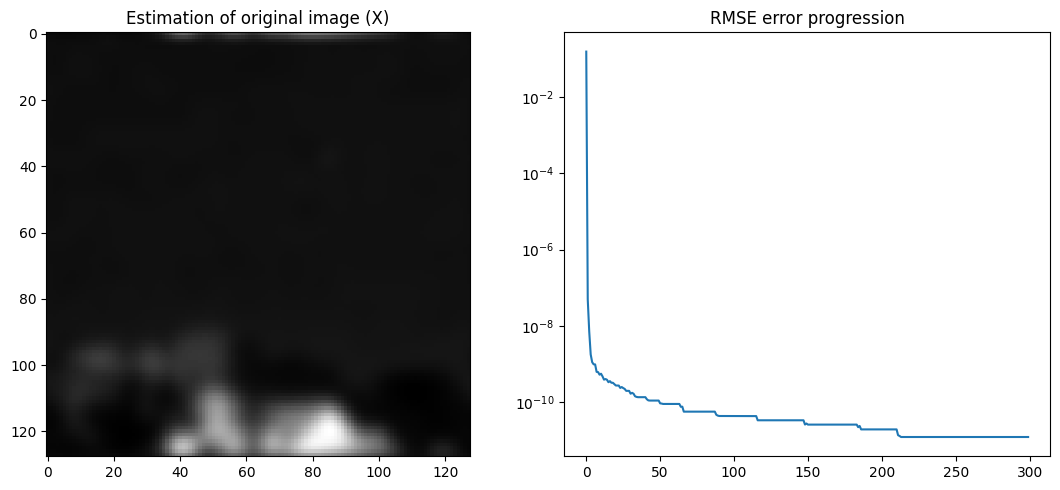

In [12]:
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_est, cmap='gray')
plt.title('Estimation of original image (X)')
plt.subplot(1, 2, 2)
plt.plot(range(len(hist_mae)), hist_mae)
plt.yscale('log')
#plt.xscale('log')
plt.title('RMSE error progression')

plt.tight_layout()
plt.show()

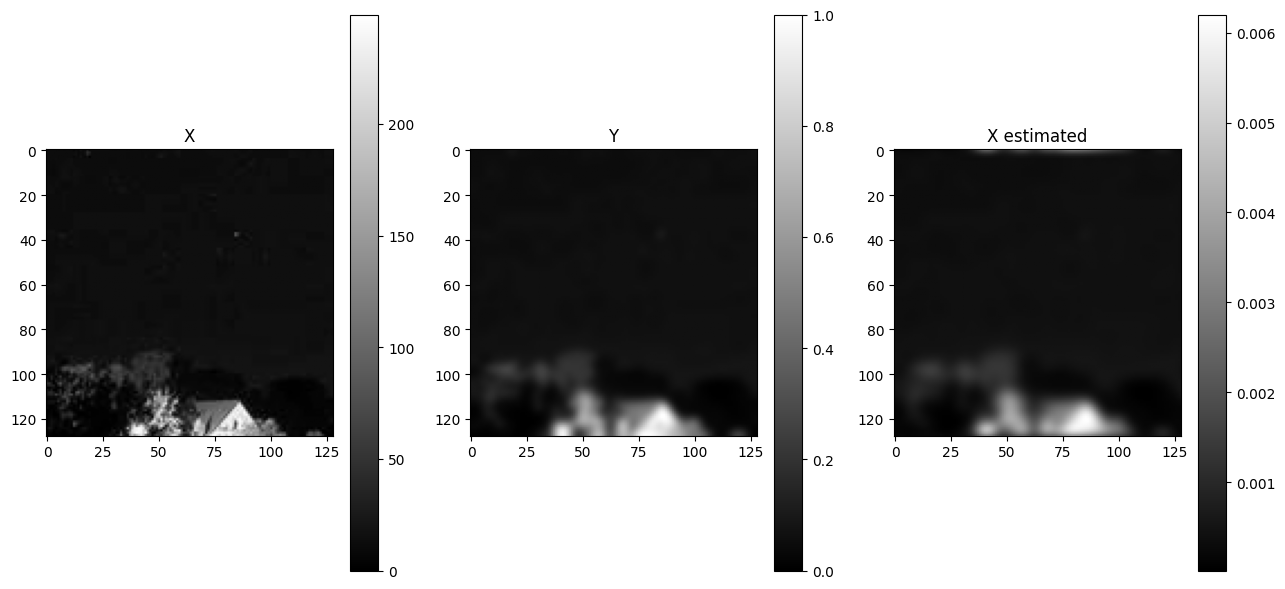

In [13]:
plt.figure(figsize=(13, 6))
plt.subplot(131)
plt.imshow(dark_sky_l, cmap='gray')
plt.colorbar()
plt.title('X')

plt.subplot(132)
plt.title('Y')
plt.imshow(Y, cmap='gray')
plt.colorbar()

plt.subplot(133)
plt.title('X estimated')
plt.imshow(X_est, cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()

Show errors:

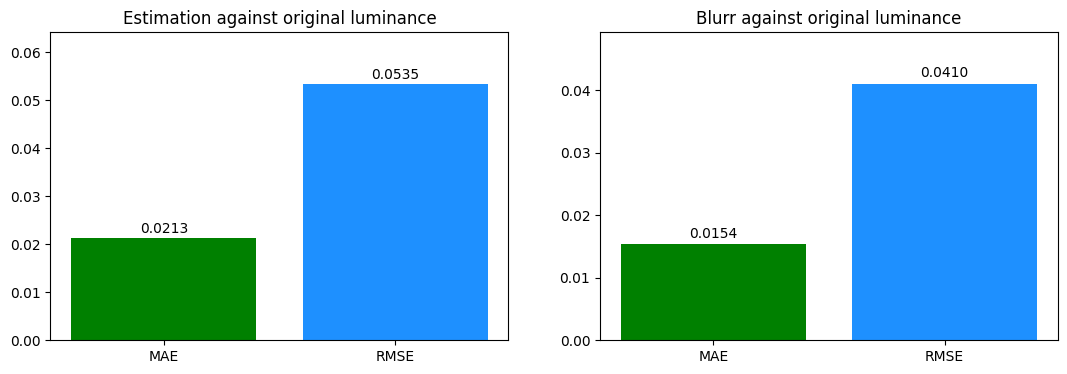

In [14]:
errs = compute_errors(normalizer(dark_sky_l), normalizer(X_est))
errs_blurr = compute_errors(normalizer(dark_sky_l), Y)
offset = 0.001

plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
bar_errors(errs, 
          title_text='Estimation against original luminance', 
          offset_text=0.001)
plt.subplot(1, 2, 2)
bar_errors(errs_blurr, 
          title_text='Blurr against original luminance',
          offset_text=0.001)
plt.show()

Compose the channels and show the results in RGB.

In [15]:
def composer(l, a, b):
    return cv.merge((l, a, b))

def lab_rgb(l, a, b):
    lab = composer(l, a, b)
    rgb = cv.cvtColor(lab, cv.COLOR_LAB2RGB)
    return rgb

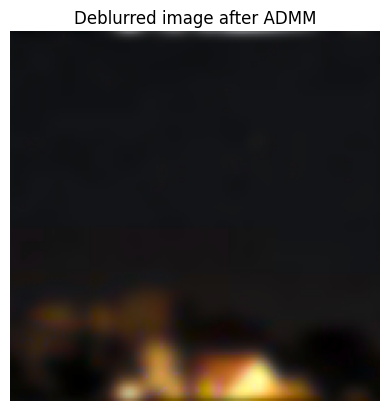

In [16]:
temp = normalizer(X_est) * 255
temp = temp.astype('uint8')

plt.imshow(lab_rgb(temp, dark_sky_a, dark_sky_b))
plt.title('Deblurred image after ADMM')
plt.axis('off')
plt.show()

## Generalization of function

Unite all function to operate on arbitrary images.

In [17]:
def deblurring_img(img, blurr_krn_sz=3, blurr_krn_sd=2, lambda_admm=.01, rho_admm=1, step=1):
    l, a, b = cv.split(cv.cvtColor(img, cv.COLOR_RGB2LAB))

    krn_blur = cv.getGaussianKernel(ksize=blurr_krn_sz, sigma=blurr_krn_sd)
    krn_blur = krn_blur @ krn_blur.T
    krn_blur = krn_blur / np.sum(krn_blur)

    l_blur = convolve2d(l, krn_blur, mode='same', boundary='symm')
    l_blur = normalizer(l_blur)

    krn_pad = pad_kernel_to_image_size(krn_blur, l_blur.shape)
    l_est, rmse_hist = admm(krn_pad, l_blur, lambd=lambda_admm, rho=rho_admm, max_iter=step, tol=1e-4)
    l_est = normalizer(l_est)
    l_errs = compute_errors(l_est, normalizer(l))
    
    l_est = (l_est * 255).astype('uint8')
    img_rgb = lab_rgb(l_est, a, b)
    return img_rgb, rmse_hist, l_errs

Test on images.

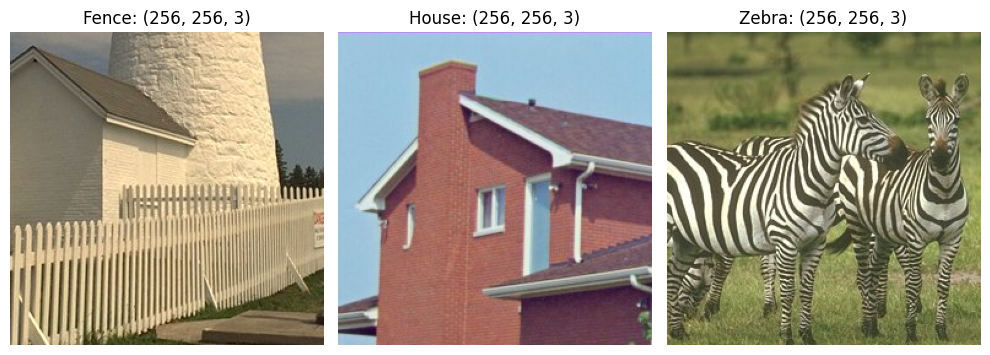

In [18]:
fence_img = cv.cvtColor(cv.imread(f'{BASE_DIR}/fence.jpg'), cv.COLOR_BGR2RGB)
house_img = cv.cvtColor(cv.imread(f'{BASE_DIR}/house.jpg'), cv.COLOR_BGR2RGB)
zebra_img = cv.cvtColor(cv.imread(f'{BASE_DIR}/zebra.jpg'), cv.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(fence_img)
plt.axis('off')
plt.title(f'Fence: {fence_img.shape}')
plt.subplot(1, 3, 2)
plt.imshow(house_img)
plt.axis('off')
plt.title(f'House: {house_img.shape}')
plt.subplot(1, 3, 3)
plt.imshow(zebra_img)
plt.axis('off')
plt.title(f'Zebra: {zebra_img.shape}')

plt.tight_layout()
plt.show()

Deblurring using kernel size of 3 and $\sigma=2$.

In [19]:
dk_deblur, dk_rmse, dk_errs = deblurring_img(dark_sky_rec, blurr_krn_sz=3, blurr_krn_sd=2, lambda_admm=.5, rho_admm=50, step=100)

Steps 100/100, Last RMSE: 8.873089801235503e-11


In [20]:
fence_deblur, fence_rmse, fence_errs = deblurring_img(fence_img, blurr_krn_sz=3, blurr_krn_sd=2, lambda_admm=.5, rho_admm=50, step=100)

Steps 100/100, Last RMSE: 1.5782879625835798e-11


In [21]:
house_deblur, house_rmse, house_errs = deblurring_img(house_img, blurr_krn_sz=3, blurr_krn_sd=2, lambda_admm=.5, rho_admm=50, step=100)

Steps 100/100, Last RMSE: 1.607443011249778e-11


In [22]:
zebra_deblur, zebra_rmse, zebra_errs = deblurring_img(zebra_img, blurr_krn_sz=3, blurr_krn_sd=2, lambda_admm=.5, rho_admm=50, step=100)

Steps 100/100, Last RMSE: 1.7154401206691753e-11


Show the results.

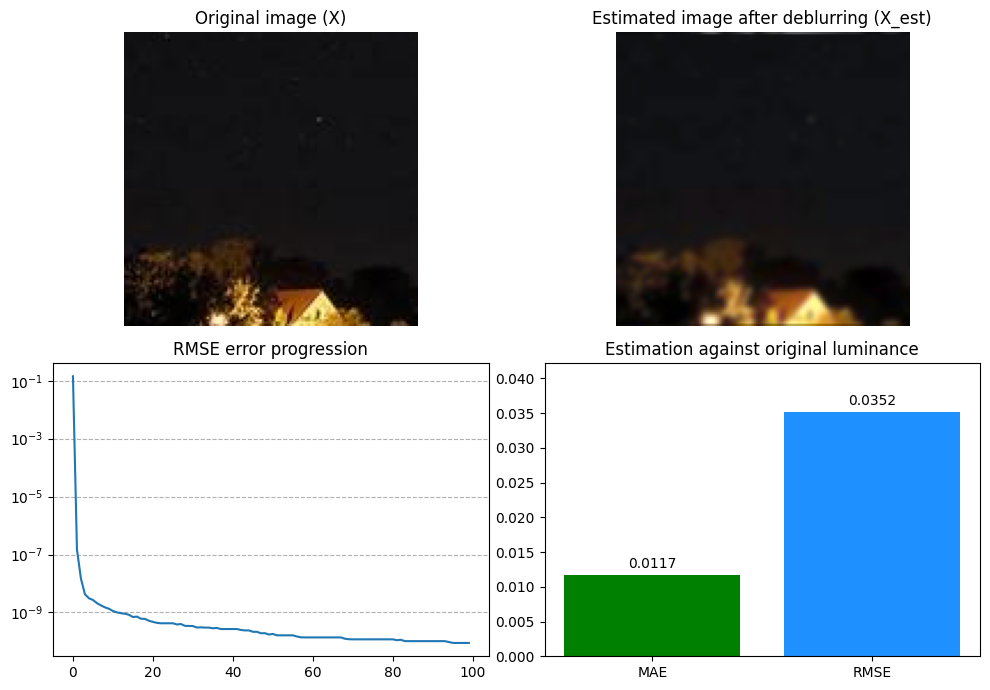

In [23]:
plt.figure(figsize=(10, 7))
plt.subplot(2, 2, 1)
plt.imshow(dark_sky_rec)
plt.title('Original image (X)')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(dk_deblur)
plt.title('Estimated image after deblurring (X_est)')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.plot(range(len(dk_rmse)), dk_rmse)
plt.yscale('log')
plt.grid(axis='y', ls='--')
plt.title('RMSE error progression')
plt.subplot(2, 2, 4)
bar_errors(dk_errs, 
          title_text='Estimation against original luminance', 
          offset_text=0.001)

plt.tight_layout()
plt.show()

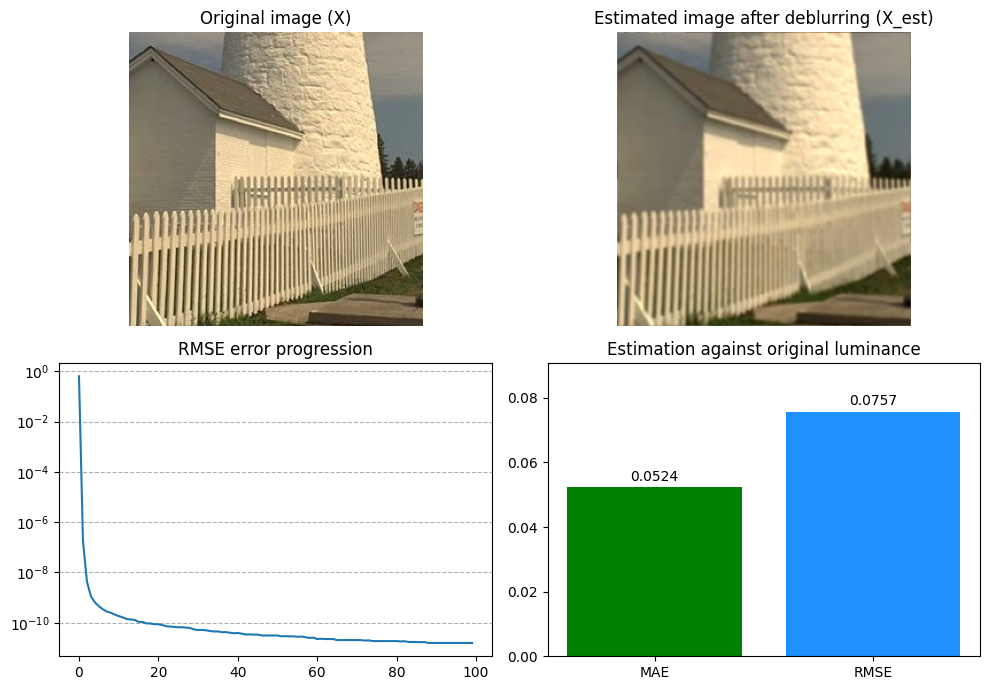

In [24]:
plt.figure(figsize=(10, 7))
plt.subplot(2, 2, 1)
plt.imshow(fence_img)
plt.title('Original image (X)')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(fence_deblur)
plt.title('Estimated image after deblurring (X_est)')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.plot(range(len(fence_rmse)), fence_rmse)
plt.yscale('log')
plt.grid(axis='y', ls='--')
plt.title('RMSE error progression')
plt.subplot(2, 2, 4)
bar_errors(fence_errs, 
          title_text='Estimation against original luminance', 
          offset_text=0.002)

plt.tight_layout()
plt.show()

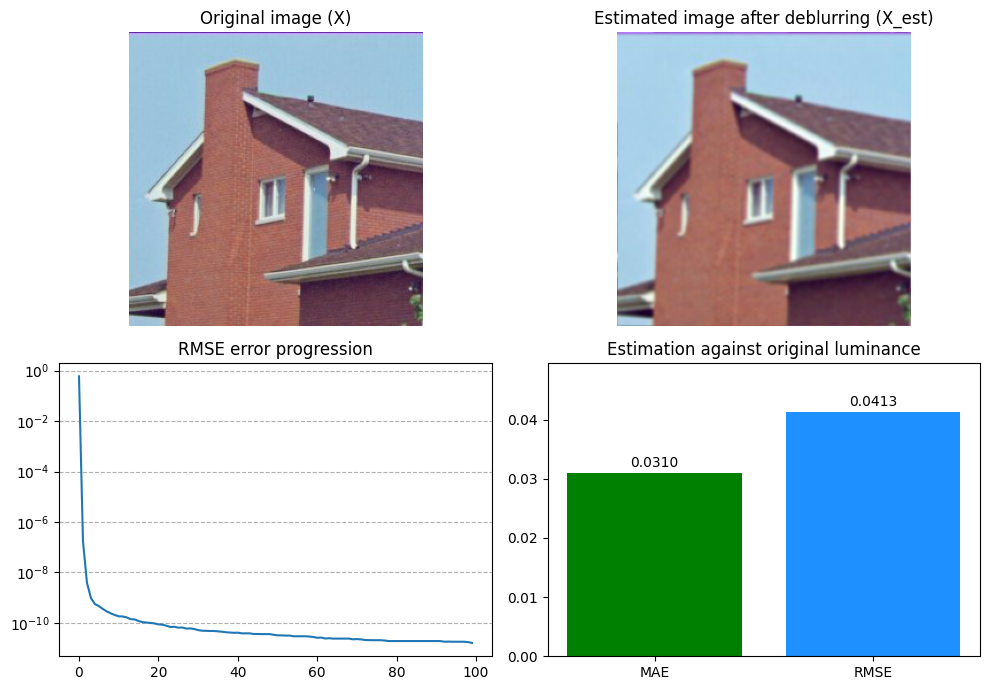

In [25]:
plt.figure(figsize=(10, 7))
plt.subplot(2, 2, 1)
plt.imshow(house_img)
plt.title('Original image (X)')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(house_deblur)
plt.title('Estimated image after deblurring (X_est)')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.plot(range(len(house_rmse)), house_rmse)
plt.yscale('log')
plt.grid(axis='y', ls='--')
plt.title('RMSE error progression')
plt.subplot(2, 2, 4)
bar_errors(house_errs, 
          title_text='Estimation against original luminance', 
          offset_text=0.001)

plt.tight_layout()
plt.show()

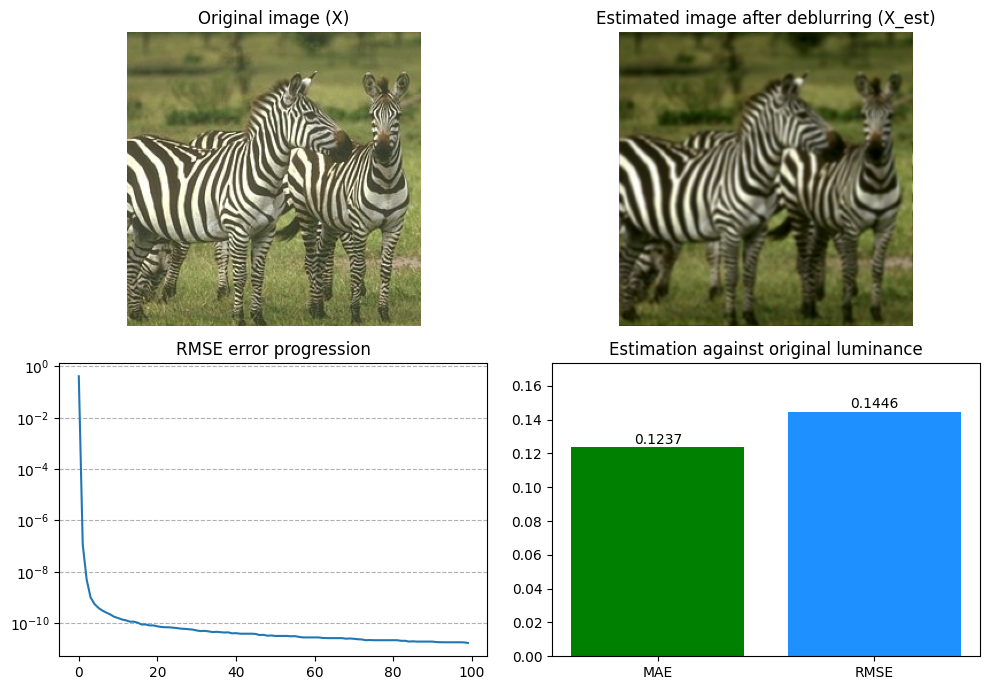

In [26]:
plt.figure(figsize=(10, 7))
plt.subplot(2, 2, 1)
plt.imshow(zebra_img)
plt.title('Original image (X)')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(zebra_deblur)
plt.title('Estimated image after deblurring (X_est)')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.plot(range(len(zebra_rmse)), zebra_rmse)
plt.yscale('log')
plt.grid(axis='y', ls='--')
plt.title('RMSE error progression')
plt.subplot(2, 2, 4)
bar_errors(zebra_errs, 
          title_text='Estimation against original luminance', 
          offset_text=0.002)

plt.tight_layout()
plt.show()